## Creating the threshold analysis and logistic regression analysis:

In [15]:
library(pROC)
library(BBmisc)
library(caret)
library(dplyr)
library(randomForest)

In [16]:
data = read.csv('../../AnnotateData/recgli_annotation10_onlyGoodBiopsies_alt1.csv')
dim(data)

[1] 366  75

In [17]:
data = data[data$outcome == "rHGG" | data$outcome == "txe", ]
dim(data)

[1] 297  75

In [18]:
data = data[data$CELorNEL == "CEL" | data$CELorNEL == "NEL",]
dim(data)

[1] 291  75

In [19]:
data = droplevels.data.frame(data)

In [20]:
id = "t_number_y"
features = c('nadc.1', 'nfa.1',
             'cbvn_nlin', 
             'ccri', 'cni', 'ncre', 'ncho', 'nnaa', 
             'in_CEL', 'newdata')
label = 'outcome'

In [21]:
data_xy = data[,c(id, features, label)]
head(data_xy)

,t_number_y,nadc.1,nfa.1,cbvn_nlin,ccri,cni,ncre,ncho,nnaa,in_CEL,newdata,outcome
1,10366,0.75,0.83,1.08,1.88,2.60,0.47,1.03,0.46,0,1,txe
3,10448,1.62,0.50,2.43,NA,NA,NA,NA,NA,1,1,rHGG
4,10594,2.62,0.81,1.64,NA,NA,NA,NA,NA,0,1,txe
5,10594,2.12,0.42,0.95,1.03,3.27,0.79,1.04,0.36,0,1,rHGG
6,10594,1.60,0.73,0.84,2.33,7.57,1.07,1.61,0.13,0,1,rHGG
7,10594,3.03,0.42,0.42,2.13,4.37,1.21,1.89,0.74,0,1,rHGG


## missing value indicators: 

In [22]:
data_xy = data.frame(data_xy, 
                    hasDiffu = ifelse(is.na(data_xy$nadc.1), 0, 1), 
                    hasPerf  = ifelse(is.na(data_xy$cbvn_nlin), 0, 1), 
                    hasSpec  = ifelse(is.na(data_xy$cni), 0, 1))

## fold splits: 

In [23]:
# 11, 32
set.seed(32)
## 32 allows for good splitting.

In [24]:
tnum_group_assignment = data.frame(t_number_y = unique(data[,id]), fold =floor(runif(length(unique(data[,id])), min = 1, max = 6)))

In [25]:
data_xy_split = merge(data_xy, tnum_group_assignment, by = c("t_number_y"))

In [26]:
data = data_xy_split

In [27]:
table(data$outcome)['txe']/length(data$outcome)

txe 
0.2371134

In [28]:
print('fold 1')
table(data$outcome[data$fold ==1])['txe']/length(data$outcome[data$fold ==1])
print('fold 2')
table(data$outcome[data$fold ==2])['txe']/length(data$outcome[data$fold ==2])
print('fold 3')
table(data$outcome[data$fold ==3])['txe']/length(data$outcome[data$fold ==3])
print('fold 4')
table(data$outcome[data$fold ==4])['txe']/length(data$outcome[data$fold ==4])
print('fold 5')
table(data$outcome[data$fold ==5])['txe']/length(data$outcome[data$fold ==5])

[1] "fold 1"


txe 
0.2903226

[1] "fold 2"


txe 
0.2698413

[1] "fold 3"


txe 
0.2105263

[1] "fold 4"


txe 
0.1833333

[1] "fold 5"


txe 
0.2244898

In [29]:
data_cel = data[which(data$in_CEL == 1),]

In [30]:
data_nel = data[which(data$in_CEL == 0),]

In [31]:
print('fold 1')
table(data_cel$outcome[data_cel$fold ==1])['txe']/length(data_cel$outcome[data_cel$fold ==1])
print('fold 2')
table(data_cel$outcome[data_cel$fold ==2])['txe']/length(data_cel$outcome[data_cel$fold ==2])
print('fold 3')
table(data_cel$outcome[data_cel$fold ==3])['txe']/length(data_cel$outcome[data_cel$fold ==3])
print('fold 4')
table(data_cel$outcome[data_cel$fold ==4])['txe']/length(data_cel$outcome[data_cel$fold ==4])
print('fold 5')
table(data_cel$outcome[data_cel$fold ==5])['txe']/length(data_cel$outcome[data_cel$fold ==5])

[1] "fold 1"


txe 
0.2647059

[1] "fold 2"


txe 
0.275

[1] "fold 3"


txe 
0.1612903

[1] "fold 4"


txe 
0.1818182

[1] "fold 5"


txe 
0.1666667

In [32]:
print('fold 1')
table(data_nel$outcome[data_nel$fold ==1])['txe']/length(data_nel$outcome[data_nel$fold ==1])
print('fold 2')
table(data_nel$outcome[data_nel$fold ==2])['txe']/length(data_nel$outcome[data_nel$fold ==2])
print('fold 3')
table(data_nel$outcome[data_nel$fold ==3])['txe']/length(data_nel$outcome[data_nel$fold ==3])
print('fold 4')
table(data_nel$outcome[data_nel$fold ==4])['txe']/length(data_nel$outcome[data_nel$fold ==4])
print('fold 5')
table(data_nel$outcome[data_nel$fold ==5])['txe']/length(data_nel$outcome[data_nel$fold ==5])

[1] "fold 1"


txe 
0.3214286

[1] "fold 2"


txe 
0.2608696

[1] "fold 3"


txe 
0.2692308

[1] "fold 4"


txe 
0.1851852

[1] "fold 5"


txe 
0.28

## thresholding: 

### NEL 

#### Choline:

In [33]:
scores_nel = data.frame(param = NA, 
                        folds = NA, 
                        thresh = NA,
                        auc_4folds = NA,
                        ci1_4folds = NA, 
                        ci2_4folds = NA,
                        
                        acc_4folds = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        ppv_4folds = NA,
                        npv_4folds = NA,
                        
                        acc_CV = NA,
                        sens_CV = NA, 
                        spec_CV = NA,
                        ppv_CV = NA,
                        npv_CV = NA
                       )

In [34]:
features_mri = features[1:8]

In [35]:
features_mri

[1] "nadc.1"    "nfa.1"     "cbvn_nlin" "ccri"      "cni"       "ncre"     
[7] "ncho"      "nnaa"

In [36]:
features

[1] "nadc.1"    "nfa.1"     "cbvn_nlin" "ccri"      "cni"       "ncre"     
 [7] "ncho"      "nnaa"      "in_CEL"    "newdata"

In [37]:
for (col in features_mri){
    for (fold in c(1:5)){
        data_thresh = data_nel[which(data_nel$fold != fold),]
        data_pred = data_nel[which(data_nel$fold == fold),]
        roc = roc(data_thresh$outcome, data_thresh[,col], levels=c("rHGG", "txe"))
#         print(col)
#         plot(roc)
        thresh = coords(roc, "best", best.method=c("closest.topleft"))['threshold']
        sens = coords(roc, "best", best.method=c("closest.topleft"))['sensitivity']
        spec = coords(roc, "best", best.method=c("closest.topleft"))['specificity']
        
        if(col == "nfa.1" | col == "nnaa"){
            preds_4folds = as.factor(ifelse(data_thresh[,col] < thresh, 'rHGG', 'txe'))
        }
        else{
            preds_4folds = as.factor(ifelse(data_thresh[,col] > thresh, 'rHGG', 'txe'))
        }
        acc_4folds =  confusionMatrix(data = preds_4folds, reference = data_thresh$outcome)$overall['Accuracy']
        ppv_4folds =  confusionMatrix(data = preds_4folds, reference = data_thresh$outcome)$byClass['Pos Pred Value']
        npv_4folds =  confusionMatrix(data = preds_4folds, reference = data_thresh$outcome)$byClass['Neg Pred Value']

        auc = auc(roc)
        ci1 = ci.auc(roc)[1]
        ci2 = ci.auc(roc)[3]
        
        if(col == "nfa.1" | col == "nnaa"){
            preds = as.factor(ifelse(data_pred[,col] < thresh, 'rHGG', 'txe'))
        }
        else{
            preds = as.factor(ifelse(data_pred[,col] > thresh, 'rHGG', 'txe'))
        }
        acc_pred =  confusionMatrix(data = preds, reference = data_pred$outcome)$overall['Accuracy']
        sens_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Sensitivity']
        spec_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Specificity']
        ppv_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Pos Pred Value']
        npv_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Neg Pred Value']
        
        newline = c(param = col, 
                        folds = fold, 
                        thresh = thresh,
                        auc_4folds = auc,
                        ci1_4folds = ci1, 
                        ci2_4folds = ci2, 
                    
                        acc_4folds = acc_4folds,
                        sens_4folds = sens, 
                        spec_4folds = spec, 
                        ppv_4folds = ppv_4folds, 
                        npv_4folds = npv_4folds, 
                    
                        acc_CV = acc_pred,
                        sens_CV = sens_pred,
                        spec_CV = spec_pred, 
                        ppv_CV = ppv_pred, 
                        npv_CV = npv_pred
                       )
        scores_nel = rbind(scores_nel, newline)

    }
}

In [38]:
scores_nel = scores_nel[-1,]

In [39]:
scores_nel$thresh = as.numeric(scores_nel$thresh)
scores_nel$acc_4folds = as.numeric(scores_nel$acc_4folds)
scores_nel$sens_4folds = as.numeric(scores_nel$sens_4folds)
scores_nel$spec_4folds = as.numeric(scores_nel$spec_4folds)
scores_nel$auc_4folds = as.numeric(scores_nel$auc_4folds)
scores_nel$ci1_4folds = as.numeric(scores_nel$ci1_4folds)
scores_nel$ci2_4folds = as.numeric(scores_nel$ci2_4folds)
scores_nel$acc_CV = as.numeric(scores_nel$acc_CV)
scores_nel$sens_CV = as.numeric(scores_nel$sens_CV)
scores_nel$spec_CV = as.numeric(scores_nel$spec_CV)

In [40]:
for (col in colnames(scores_nel)[2:length(colnames(scores_nel))]){
    scores_nel[col] = as.numeric(unlist(scores_nel[col]))
}


In [41]:
scores_nel_cni = scores_nel[scores_nel$param == "cni",]

In [42]:
cni_results = data.frame(mean = apply(scores_nel_cni[,c(3:12)], 2, mean), 
                         sd = apply(scores_nel_cni[,c(3:12)], 2, sd))
cni_results

,mean,sd
thresh,2.7070000,0.06408978
auc_4folds,0.6790352,0.01200486
ci1_4folds,0.5421489,0.01382726
ci2_4folds,0.8159214,0.01309314
acc_4folds,0.6815985,0.01453229
sens_4folds,0.8738095,0.04579853
spec_4folds,0.6219642,0.02103979
ppv_4folds,0.9437728,0.01487066
npv_4folds,0.4124668,0.04783737
acc_CV,0.6883333,0.09554415


In [43]:
scores_nel_ncho = scores_nel[scores_nel$param == "ncho",]

ncho_results = data.frame(mean = apply(scores_nel_ncho[,c(3:12)], 2, mean),
           std = apply(scores_nel_ncho[,c(3:12)], 2, sd))
ncho_results

,mean,std
thresh,1.0910000,0.03130495
auc_4folds,0.7082125,0.02850452
ci1_4folds,0.5705559,0.03147362
ci2_4folds,0.8458691,0.02732664
acc_4folds,0.6562021,0.02811383
sens_4folds,0.7476190,0.04864956
spec_4folds,0.6270924,0.02861019
ppv_4folds,0.8922746,0.01009515
npv_4folds,0.3794074,0.05982648
acc_CV,0.6566667,0.13433299


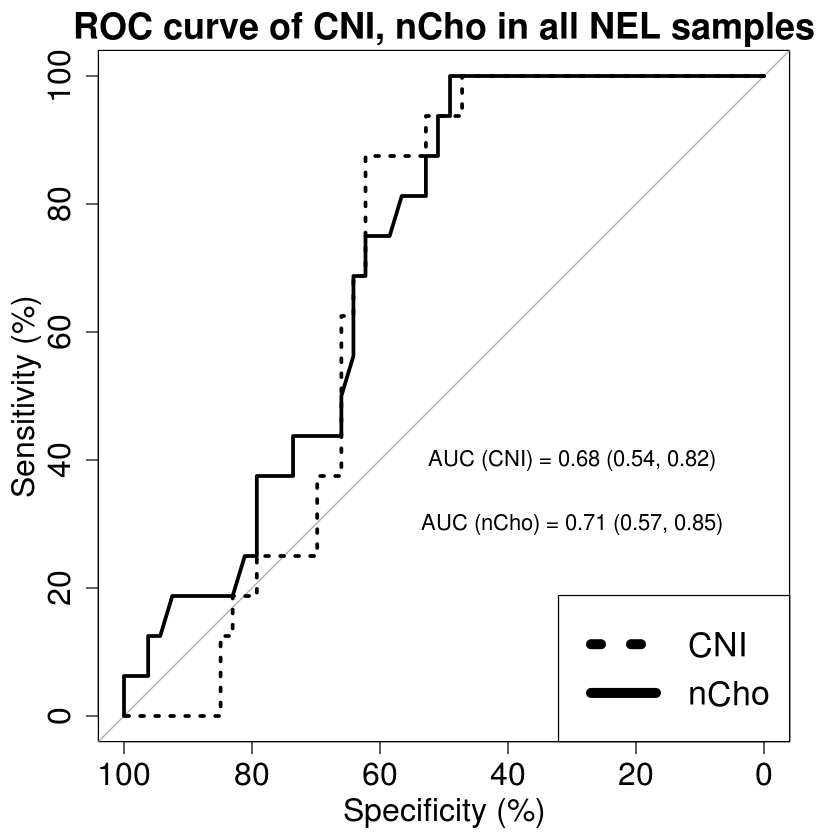

In [44]:
fold = 1
data_thresh = data_nel[which(data_nel$fold != fold),]
par(cex.axis=1.6, cex.lab=1.6, cex.main=1.8, cex.sub=1)

cni_roc = plot.roc(data_nel$outcome, data_nel[,'cni'], levels=c("rHGG", "txe"), 
          percent = TRUE, col = "#000001", main = "ROC curve of CNI, nCho in all NEL samples", lwd=3, lty = "dotted")
cho_roc = lines.roc(data_nel$outcome, data_nel$ncho, levels = c('rHGG', 'txe'), percent = TRUE, col = "#000000", lwd=3)
legend("bottomright", legend=c("CNI", "nCho"), col=c("#000001", "#000000"), lwd=8, lty = c("dotted", "solid"),cex = 1.7)
text(x = 30, y = 40, labels = paste('AUC (CNI) = ', round(cni_results['auc_4folds', 'mean'], 2), 
                                    " (",round(cni_results['ci1_4folds', 'mean'], 2) ,", ",
                                    round(cni_results['ci2_4folds', 'mean'], 2), ")", sep = ""), adj = NULL,
     pos = NULL, offset = 0.5, vfont = NULL,
     cex = 1.1, col = NULL, font = NULL)
text(x = 30, y = 30, labels = paste('AUC (nCho) = ', round(ncho_results['auc_4folds', 'mean'], 2), 
                                    " (",round(ncho_results['ci1_4folds', 'mean'], 2) ,", ",
                                    round(ncho_results['ci2_4folds', 'mean'], 2), ")", sep = ""), adj = NULL,
     pos = NULL, offset = 0.5, vfont = NULL,
     cex = 1.1, col = NULL, font = NULL)




## CEL

In [45]:
summary(data_cel$cbvn_nlin)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.010   1.143   1.615   1.899   2.370   5.720      56 

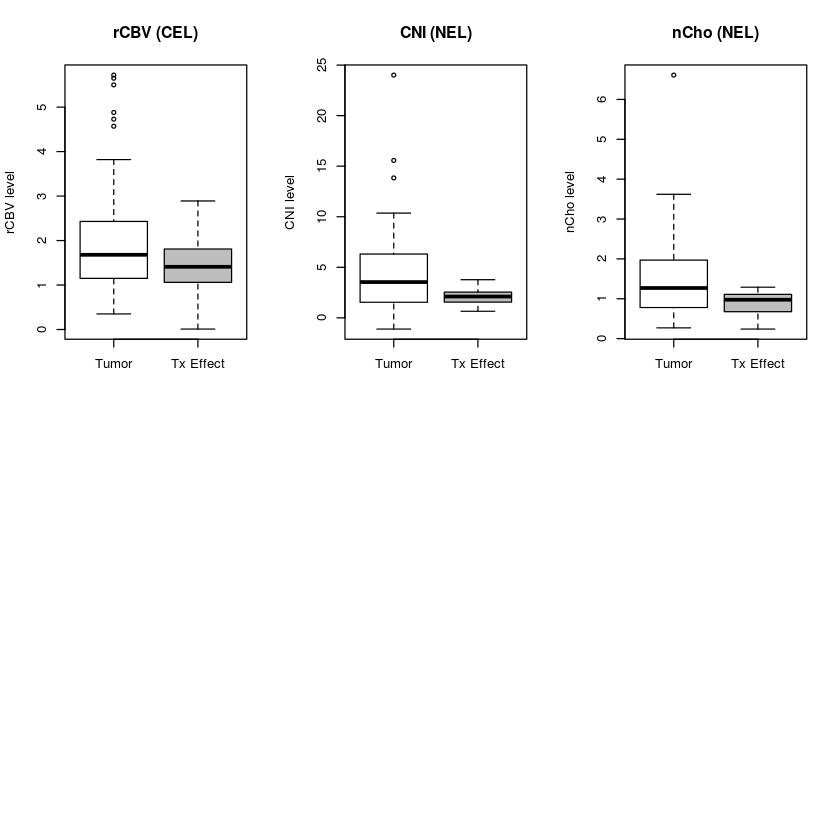

In [46]:
par(mfrow = c(2, 3))
boxplot(cbvn_nlin ~ outcome, data_cel, 
       main = "rCBV (CEL)", 
       names = c('Tumor', 'Tx Effect'),
       col = c('white', 'gray'), 
       ylab = 'rCBV level')

boxplot(cni ~ outcome, data_nel, 
       main = "CNI (NEL)", 
       names = c('Tumor', 'Tx Effect'),
       col = c('white', 'gray'), 
       ylab = 'CNI level')

boxplot(ncho ~ outcome, data_nel, 
       main = "nCho (NEL)", 
       names = c('Tumor', 'Tx Effect'),
       col = c('white', 'gray'), 
       ylab = 'nCho level')


In [43]:
scores_cel = data.frame(param = NA, 
                        folds = NA, 
                        thresh = NA,
                        auc_4folds = NA,
                        ci1_4folds = NA, 
                        ci2_4folds = NA,
                        
                        acc_4folds = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        ppv_4folds = NA,
                        npv_4folds = NA,
                        
                        acc_CV = NA,
                        sens_CV = NA, 
                        spec_CV = NA,
                        ppv_CV = NA,
                        npv_CV = NA
                       )

In [44]:
for (col in features_mri){
    for (fold in c(1:5)){
        data_thresh = data_cel[which(data_cel$fold != fold),]
        data_pred = data_cel[which(data_cel$fold == fold),]
        roc = roc(data_thresh$outcome, data_thresh[,col], levels=c("rHGG", "txe"))
#         print(col)
#         plot(roc)
        thresh = coords(roc, "best", best.method=c("closest.topleft"))['threshold']
        sens = coords(roc, "best", best.method=c("closest.topleft"))['sensitivity']
        spec = coords(roc, "best", best.method=c("closest.topleft"))['specificity']
        
        if(col == "nfa.1" | col == "nnaa"){
            preds_4folds = as.factor(ifelse(data_thresh[,col] < thresh, 'rHGG', 'txe'))
        }
        else{
            preds_4folds = as.factor(ifelse(data_thresh[,col] > thresh, 'rHGG', 'txe'))
        }
        acc_4folds =  confusionMatrix(data = preds_4folds, reference = data_thresh$outcome)$overall['Accuracy']
        ppv_4folds =  confusionMatrix(data = preds_4folds, reference = data_thresh$outcome)$byClass['Pos Pred Value']
        npv_4folds =  confusionMatrix(data = preds_4folds, reference = data_thresh$outcome)$byClass['Neg Pred Value']

        auc = auc(roc)
        ci1 = ci.auc(roc)[1]
        ci2 = ci.auc(roc)[3]
        
        if(col == "nfa.1" | col == "nnaa"){
            preds = as.factor(ifelse(data_pred[,col] < thresh, 'rHGG', 'txe'))
        }
        else{
            preds = as.factor(ifelse(data_pred[,col] > thresh, 'rHGG', 'txe'))
        }
        acc_pred =  confusionMatrix(data = preds, reference = data_pred$outcome)$overall['Accuracy']
        sens_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Sensitivity']
        spec_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Specificity']
        ppv_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Pos Pred Value']
        npv_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Neg Pred Value']
        
        newline = c(param = col, 
                        folds = fold, 
                        thresh = thresh,
                        auc_4folds = auc,
                        ci1_4folds = ci1, 
                        ci2_4folds = ci2, 
                    
                        acc_4folds = acc_4folds,
                        sens_4folds = sens, 
                        spec_4folds = spec, 
                        ppv_4folds = ppv_4folds, 
                        npv_4folds = npv_4folds, 
                    
                        acc_CV = acc_pred,
                        sens_CV = sens_pred,
                        spec_CV = spec_pred, 
                        ppv_CV = ppv_pred, 
                        npv_CV = npv_pred
                       )
        scores_cel = rbind(scores_cel, newline)

    }
}

In [45]:
for (col in colnames(scores_cel)[2:length(colnames(scores_cel))]){
    scores_cel[col] = as.numeric(unlist(scores_cel[col]))
}


In [46]:
scores_cel_cbv = scores_cel[scores_cel$param == "cbvn_nlin",]

In [47]:
scores_cel_cbv=scores_cel_cbv[-1,]

In [48]:
scores_cel_cbv

,param,folds,thresh,auc_4folds,ci1_4folds,ci2_4folds,acc_4folds,sens_4folds,spec_4folds,ppv_4folds,npv_4folds,acc_CV,sens_CV,spec_CV,ppv_CV,npv_CV
12,cbvn_nlin,1,1.245,0.5927230,0.4305397,0.7549063,0.6506024,0.5000000,0.6760563,0.8888889,0.2068966,0.6086957,0.6666667,0.4000000,0.8000000,0.25000000
13,cbvn_nlin,2,1.615,0.6436275,0.5003713,0.7868836,0.5783133,0.6666667,0.5588235,0.8837209,0.2500000,0.4347826,0.4285714,0.5000000,0.9000000,0.07692308
14,cbvn_nlin,3,1.615,0.6547619,0.5045246,0.8049992,0.5617978,0.7500000,0.5324675,0.9318182,0.2000000,0.4705882,0.5000000,0.4000000,0.6666667,0.25000000
15,cbvn_nlin,4,1.645,0.6034664,0.4559660,0.7509667,0.5609756,0.6428571,0.5441176,0.8809524,0.2250000,0.4583333,0.4285714,0.6666667,0.9000000,0.14285714
16,cbvn_nlin,5,1.830,0.6101852,0.4619098,0.7584606,0.4827586,0.7333333,0.4305556,0.8857143,0.2115385,0.5263158,0.4705882,1.0000000,1.0000000,0.18181818


In [49]:

cbv_results = data.frame(median = apply( scores_cel_cbv[,c(3:12)], 2, median),
           mean = apply( scores_cel_cbv[,c(3:12)], 2, mean), sd = apply(scores_cel_cbv[,c(3:12)], 2, sd))
cbv_results

,median,mean,sd
thresh,1.6150000,1.5900000,0.21266170
auc_4folds,0.6101852,0.6209528,0.02681340
ci1_4folds,0.4619098,0.4706623,0.03135158
ci2_4folds,0.7584606,0.7712433,0.02358769
acc_4folds,0.5617978,0.5668895,0.05974374
sens_4folds,0.6666667,0.6585714,0.09925459
spec_4folds,0.5441176,0.5484041,0.08741322
ppv_4folds,0.8857143,0.8942189,0.02121704
npv_4folds,0.2115385,0.2186870,0.01974638
acc_CV,0.4705882,0.4997431,0.06957264


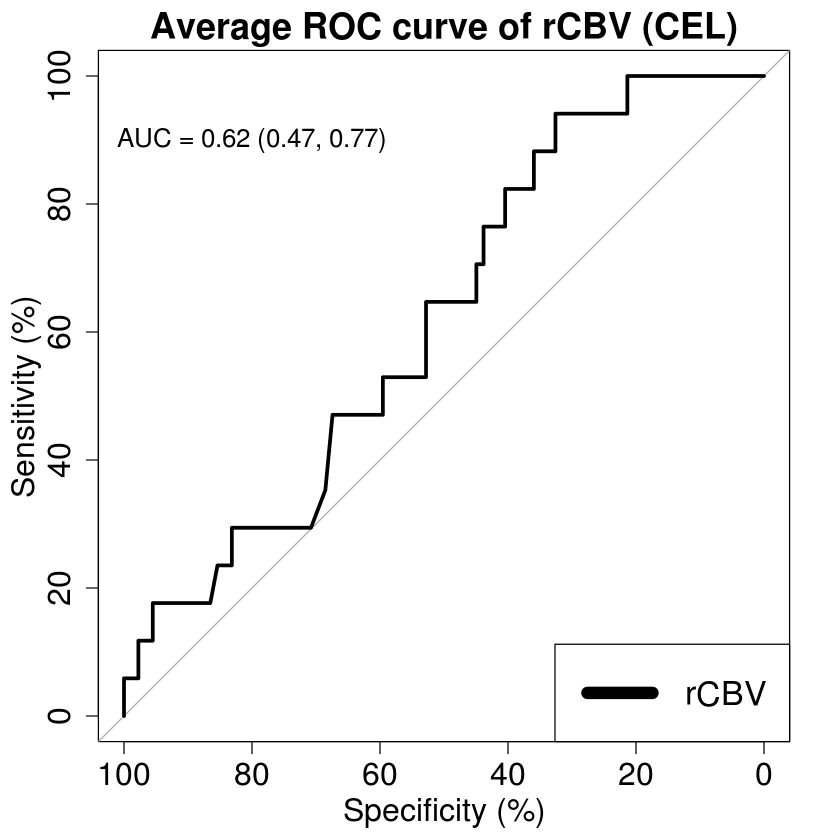

In [50]:
fold = 5
data_thresh = data_cel[which(data_cel$fold != fold),]
par(cex.axis=1.6, cex.lab=1.6, cex.main=1.8, cex.sub=1)
cbvn_nlin_roc = plot.roc(data_cel$outcome, data_cel[,'cbvn_nlin'], levels=c("rHGG", "txe"), 
          percent = TRUE, lwd=3, col = "#000000", main = "Average ROC curve of rCBV (CEL)" )
legend("bottomright", legend=c("rCBV"), col=c("#000000"), lwd=10, cex = 1.7)
text(x = 80, y = 90, labels = paste('AUC = ', round(cbv_results['auc_4folds', 'mean'], 2), 
                                    " (",round(cbv_results['ci1_4folds', 'mean'], 2) ,", ",
                                    round(cbv_results['ci2_4folds', 'mean'], 2), ")", sep = ""), adj = NULL,
     pos = NULL, offset = 0.5, vfont = NULL,
     cex = 1.3, col = NULL, font = NULL)

## All 

In [40]:
scores_all = data.frame(param = NA, 
                        folds = NA, 
                        thresh = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        sens_CV = NA, 
                        spec_CV = NA
                       )

In [41]:
for (col in features_mri){
    for (fold in c(1:5)){
        data_thresh = data[which(data$fold != fold),]
        data_pred = data[which(data$fold == fold),]
        roc = roc(data_thresh$outcome, data_thresh[,col], levels=c("rHGG", "txe"))
        thresh = coords(roc, "best", best.method=c("closest.topleft"))['threshold']
        sens = coords(roc, "best", best.method=c("closest.topleft"))['sensitivity']
        spec = coords(roc, "best", best.method=c("closest.topleft"))['specificity']
        
        if(col == "nfa.1" | col == "nnaa"){
            preds = as.factor(ifelse(data_pred[,col] < thresh, 'rHGG', 'txe'))
        }
        else{
            preds = as.factor(ifelse(data_pred[,col] > thresh, 'rHGG', 'txe'))
        }
        sens_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Sensitivity']
        spec_pred = confusionMatrix(data = preds, reference = data_pred$outcome)$byClass['Specificity']
        
        newline = c(param = col, 
                        folds = fold, 
                        thresh = thresh,
                        sens_4folds = sens, 
                        spec_4folds = spec, 
                        sens_CV = sens_pred, 
                        spec_CV = spec_pred
                       )
        scores_all = rbind(scores_all, newline)

    }
}



In [42]:
head(scores_all)

param,folds,thresh,sens_4folds,spec_4folds,sens_CV,spec_CV
NA,NA,NA,NA,NA,NA,NA
nadc.1,1,1.595,0.625,0.549707602339181,0.48780487804878,0.3125
nadc.1,2,1.595,0.51063829787234,0.548192771084337,0.5,0.647058823529412
nadc.1,3,1.595,0.538461538461538,0.52046783625731,0.609756097560976,0.583333333333333
nadc.1,4,1.645,0.490566037735849,0.545454545454545,0.425531914893617,0.818181818181818
nadc.1,5,1.595,0.571428571428571,0.52,0.621621621621622,0.375


## Logistic regression!

In [43]:
data$outcome_bin = ifelse(data$outcome =="rHGG", 1, 0)

In [44]:
head(data)

t_number_y,nadc.1,nfa.1,cbvn_nlin,ccri,cni,ncre,ncho,nnaa,in_CEL,newdata,outcome,hasDiffu,hasPerf,hasSpec,fold,outcome_bin
5296,NA,NA,0.98,NA,NA,NA,NA,NA,0,0,rHGG,0,1,0,1,1
5317,1.87,0.46,2.24,0.3,1.84,0.74,0.78,0.36,1,0,rHGG,1,1,1,3,1
5317,1.90,0.46,1.71,1.2,2.04,0.89,1.18,0.73,1,0,rHGG,1,1,1,3,1
5333,1.52,1.50,0.69,NA,NA,NA,NA,NA,1,0,rHGG,1,1,0,5,1
5333,1.32,1.06,0.85,NA,NA,NA,NA,NA,0,0,rHGG,1,1,0,5,1
5361,1.63,1.19,NA,NA,NA,NA,NA,NA,0,0,txe,1,0,0,3,0


In [45]:
set.seed(1)

## here I'm doing LR for all samples, CEL & NEL, all features: 

In [46]:
scores_lr  = data.frame(folds = NA,  auc_4folds = NA,
                        ci1_4folds = NA, 
                        ci2_4folds = NA,
                        acc_4folds = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        acc_CV = NA,
                        sens_CV = NA, 
                        spec_CV = NA
                       )

In [47]:
for (fold in c(1:5)){
    ## divide data 
    data_thresh = data[which(data$fold != fold),]
    data_pred = data[which(data$fold == fold),]
    
    ## cycle through cols to normalize: 
    for (col in features_mri){        
        ## standardization: 
        med_col = median(data_thresh[,col], na.rm = T)
        sd_col = sd(data_thresh[,col], na.rm = T)
        
        data_thresh[,col] = (data_thresh[,col]-med_col)/sd_col
        data_pred[,col] = (data_pred[,col]-med_col)/sd_col

        ##missing value filling: 
        data_thresh[,col] = ifelse(is.na(data_thresh[,col]), med_col, data_thresh[,col])
        data_pred[,col] = ifelse(is.na(data_pred[,col]), med_col, data_pred[,col])
    }
    
    ## create logReg for fold: 
    outcome = "outcome"
    features = c( 'cbvn_nlin',
                 'ccri', 'cni', 'ncho', 'ncre', 'nnaa', 'nfa.1', 'nadc.1')
    features.addsign <- paste(features, collapse = "+")
    lr_formula = as.formula(paste(outcome, features.addsign, sep = "~"))
    lr.fit = glm(lr_formula, data = data_thresh, family = binomial)
    print(summary(lr.fit))
    ## predict on training data: (4folds)
    fit.probs.data_thresh = predict(lr.fit, data_thresh, family = binomial, type = "response")
    fit.preds.data_thresh = as.factor(ifelse(fit.probs.data_thresh > 0.25, "txe", 'rHGG'))
    
    auc = (auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
          percent = TRUE)))
    auc.ci1 = ci.auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
        percent = TRUE))[1]
    auc.ci2 = ci.auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
        percent = TRUE))[3]
    acc =  confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$overall['Accuracy']
    sens = confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$byClass['Sensitivity']
    spec = confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$byClass['Specificity']
    
    ## predict on test   data: (5th fold)
    fit.probs.data_pred = predict(lr.fit, data_pred, family = binomial, type = "response")
    fit.preds.data_pred = as.factor(ifelse(fit.probs.data_pred > 0.25, "txe", 'rHGG'))
    
    ## save the coefficients & p-values
    
    
    acc_5 =  confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$overall['Accuracy']
    sens_5 = confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$byClass['Sensitivity']
    spec_5 = confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$byClass['Specificity']

    SAVE_FOLD = c(fold, auc, auc.ci1, auc.ci2, acc, sens, spec, acc_5, sens_5, spec_5)
    scores_lr = rbind(scores_lr, SAVE_FOLD)
}




Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1507  -0.7812  -0.5551  -0.3007   2.3284  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.59147    0.29303  -5.431  5.6e-08 ***
cbvn_nlin   -0.36265    0.19630  -1.847   0.0647 .  
ccri         0.16332    1.25385   0.130   0.8964    
cni          0.65169    0.59877   1.088   0.2764    
ncho        -1.34413    1.05366  -1.276   0.2021    
ncre        -0.02414    0.98289  -0.025   0.9804    
nnaa         0.55824    0.28883   1.933   0.0533 .  
nfa.1        0.13088    0.18621   0.703   0.4821    
nadc.1      -0.23564    0.18982  -1.241   0.2145    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 242.88  on 228  degrees of freedom
Residual deviance: 225.19  on 220  degrees of freedom
AIC: 243.19

Number of Fisher Scori

In [48]:
scores_lr = scores_lr[-1, ]

In [49]:
data.frame(med = apply(scores_lr , 2, median), mean = apply(scores_lr , 2, mean), sd = apply(scores_lr, 2, sd))


,med,mean,sd
folds,3.0000000,3.0000000,1.58113883
auc_4folds,65.7124126,65.4300969,1.99599065
ci1_4folds,58.0509312,57.8034912,2.01727862
ci2_4folds,73.3683171,73.0567026,2.01137739
acc_4folds,0.5811966,0.6018617,0.04590439
sens_4folds,0.5706522,0.5933063,0.08407300
spec_4folds,0.6034483,0.6236213,0.09193580
acc_CV,0.5555556,0.5116812,0.10846748
sens_CV,0.6304348,0.5460147,0.12963267
spec_CV,0.4166667,0.4024064,0.05669703


## here I'm doing LR for all samples, CEL & NEL, only important features: 

In [50]:
scores_lr_onlyImportant  = data.frame(
                        folds = NA, 
                        features = NA, 
                        auc_4folds = NA,
                        ci1_4folds = NA,
                        ci2_4folds = NA,
                        acc_4folds = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        acc_CV = NA,
                        sens_CV = NA, 
                        spec_CV = NA
                       )


Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9846  -0.7307  -0.6328  -0.4986   2.0528  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.3064     0.2846  -4.590 4.42e-06 ***
cbvn_nlin    -0.2427     0.1914  -1.268   0.2049    
ncre         -0.2083     0.2634  -0.791   0.4291    
cni           0.2417     0.1195   2.023   0.0431 *  
in_CEL       -0.2429     0.3452  -0.703   0.4818    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 242.88  on 228  degrees of freedom
Residual deviance: 236.71  on 224  degrees of freedom
AIC: 246.71

Number of Fisher Scoring iterations: 4


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "i

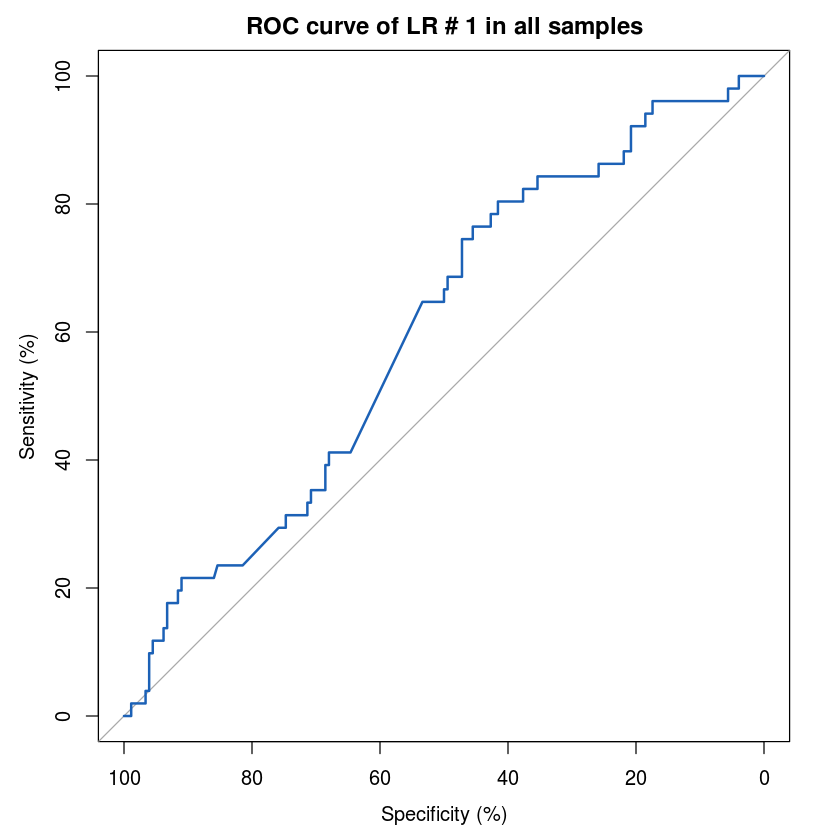


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 176 controls (data_thresh$outcome rHGG) < 52 cases (data_thresh$outcome txe).
Area under the curve: 61.65%

Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0016  -0.7902  -0.6841  -0.4515   1.9912  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.2351     0.2823  -4.376 1.21e-05 ***
cbvn_nlin    -0.2182     0.1851  -1.179   0.2385    
ncre         -0.2638     0.2927  -0.901   0.3674    
cni           0.2348     0.1238   1.896   0.0579 .  
in_CEL       -0.1430     0.3310  -0.432   0.6657    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    N

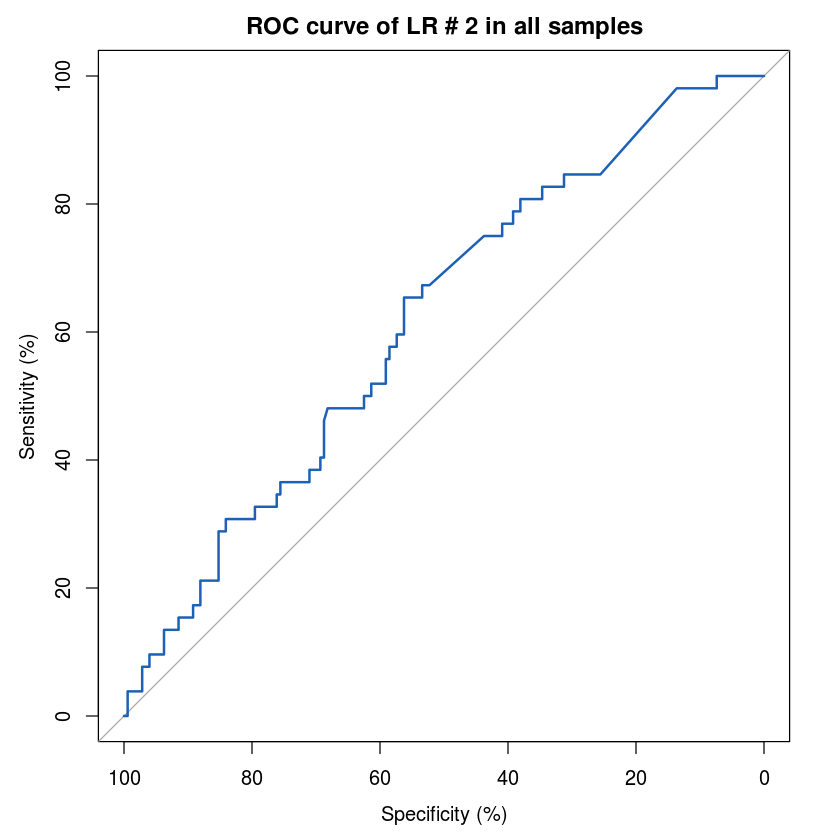


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 177 controls (data_thresh$outcome rHGG) < 57 cases (data_thresh$outcome txe).
Area under the curve: 59.93%

Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0158  -0.7899  -0.7166   0.4719   1.9466  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.9935     0.2828  -3.513 0.000443 ***
cbvn_nlin    -0.1379     0.1623  -0.849 0.395605    
ncre         -0.2058     0.2331  -0.883 0.377359    
cni           0.1211     0.1080   1.121 0.262400    
in_CEL       -0.3044     0.3175  -0.959 0.337574    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    N

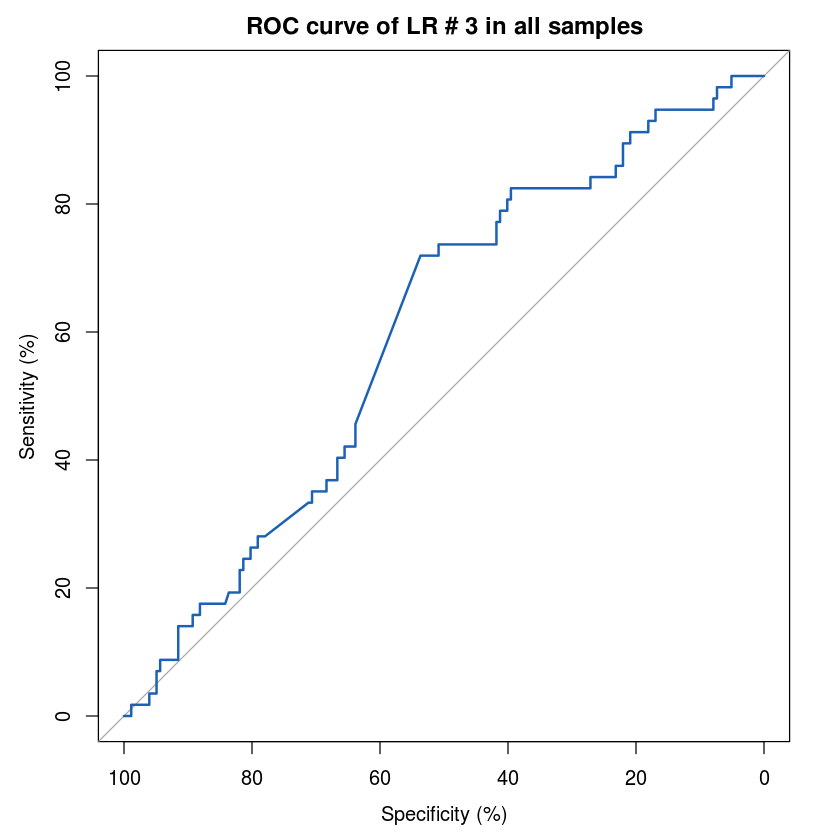


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 173 controls (data_thresh$outcome rHGG) < 58 cases (data_thresh$outcome txe).
Area under the curve: 57.82%

Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1900  -0.7686  -0.6819  -0.4934   1.8529  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.9814     0.2825  -3.474 0.000513 ***
cbvn_nlin    -0.2439     0.1771  -1.377 0.168552    
ncre         -0.3902     0.3053  -1.278 0.201222    
cni           0.1040     0.1183   0.879 0.379405    
in_CEL       -0.1654     0.3200  -0.517 0.605248    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    N

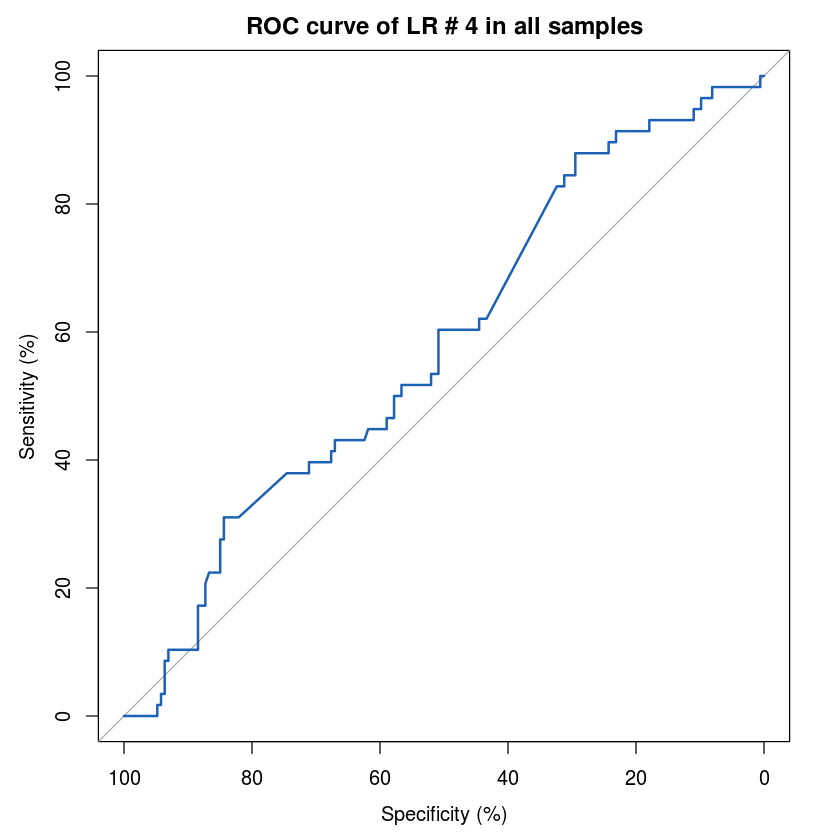


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 184 controls (data_thresh$outcome rHGG) < 58 cases (data_thresh$outcome txe).
Area under the curve: 56.48%


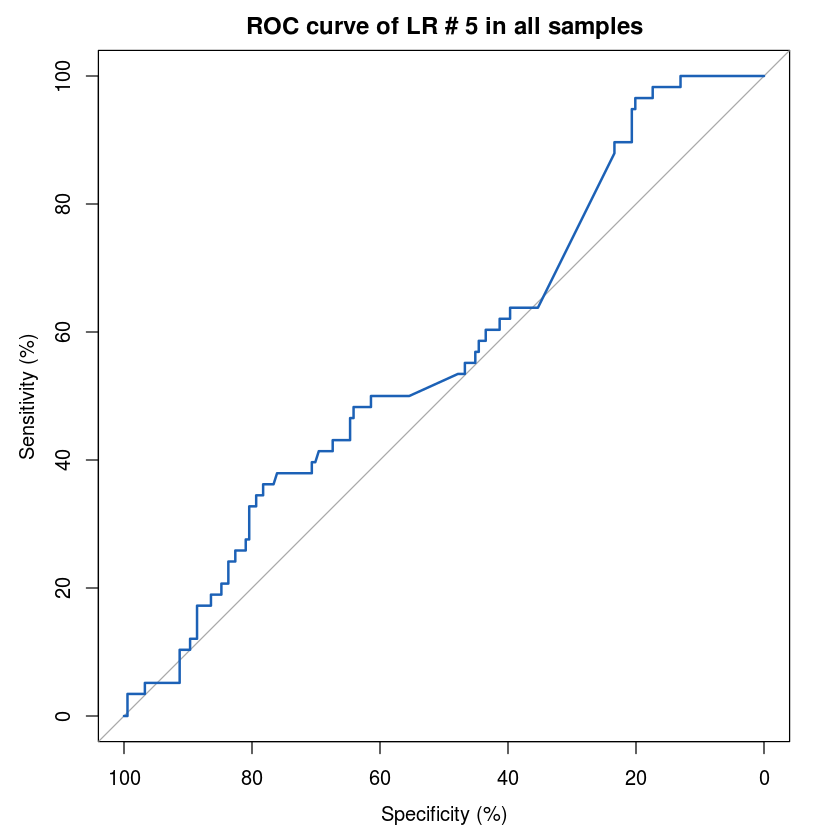

In [51]:
for (fold in c(1:5)){
    ## divide data 
    data_thresh = data[which(data$fold != fold),]
    data_pred = data[which(data$fold == fold),]
    
    ## cycle through cols to normalize: 
    for (col in features_mri){        
        ## standardization: 
        med_col = median(data_thresh[,col], na.rm = T)
        sd_col = sd(data_thresh[,col], na.rm = T)
        
        data_thresh[,col] = (data_thresh[,col]-med_col)/sd_col
        data_pred[,col] = (data_pred[,col]-med_col)/sd_col

        ##missing value filling: 
        data_thresh[,col] = ifelse(is.na(data_thresh[,col]), med_col, data_thresh[,col])
        data_pred[,col] = ifelse(is.na(data_pred[,col]), med_col, data_pred[,col])
    }
    
    ## create logReg for fold: 
    outcome = "outcome"
    features = c('cbvn_nlin', 'ncre',
                 'cni','in_CEL')
    features.addsign <- paste(features, collapse = "+")
    lr_formula = as.formula(paste(outcome, features.addsign, sep = "~"))
    lr.fit = glm(lr_formula, data = data_thresh, family = binomial)
    print(summary(lr.fit))
    ## predict on training data: (4folds)
    fit.probs.data_thresh = predict(lr.fit, data_thresh, family = binomial, type = "response")
    fit.preds.data_thresh = as.factor(ifelse(fit.probs.data_thresh > 0.25, "txe", 'rHGG'))
    print(plot.roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("rHGG", "txe"), 
          percent = TRUE, col = "#1c61b6", main = paste("ROC curve of LR #", fold, "in all samples")))
    auc = auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
          percent = TRUE))
    auc.ci1 = ci.auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
          percent = TRUE))[1]
    auc.ci2 = ci.auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
          percent = TRUE))[3]
    
    acc =  confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$overall['Accuracy']
    sens = confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$byClass['Sensitivity']
    spec = confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$byClass['Specificity']
    
    ## predict on test   data: (5th fold)
    fit.probs.data_pred = predict(lr.fit, data_pred, family = binomial, type = "response")

    thresh = 0.25
    fit.preds.data_pred = as.factor(ifelse(fit.probs.data_pred > thresh, "txe", 'rHGG'))

    ## save the coefficients & p-values

    acc_5 =  confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$overall['Accuracy']
    sens_5 = confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$byClass['Sensitivity']
    spec_5 = confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$byClass['Specificity']

    SAVE_FOLD = c(fold, features.addsign, auc, auc.ci1, auc.ci2, acc, sens, spec, acc_5, sens_5, spec_5)
    scores_lr_onlyImportant = rbind(scores_lr_onlyImportant, SAVE_FOLD)
    
}



In [52]:
scores_lr_onlyImportant = scores_lr_onlyImportant[-1,-c(1,2)]

In [53]:
scores_lr_onlyImportant

,auc_4folds,ci1_4folds,ci2_4folds,acc_4folds,sens_4folds,spec_4folds,acc_CV,sens_CV,spec_CV
2,60.2390394359991,51.8192344497251,68.6588444222731,0.620087336244541,0.696629213483146,0.352941176470588,0.467741935483871,0.477272727272727,0.444444444444444
3,61.6477272727273,53.2891758044465,70.006278741008,0.62280701754386,0.664772727272727,0.480769230769231,0.587301587301587,0.717391304347826,0.235294117647059
4,59.9316086827238,51.9019757033382,67.9612416621093,0.581196581196581,0.536723163841808,0.719298245614035,0.43859649122807,0.4,0.583333333333333
5,57.8234004385091,49.548946663586,66.0978542134322,0.532467532467532,0.53757225433526,0.517241379310345,0.55,0.571428571428571,0.454545454545455
6,56.4842578710645,48.2127297602068,64.7557859819221,0.59504132231405,0.630434782608696,0.482758620689655,0.571428571428571,0.605263157894737,0.454545454545455


In [54]:
scores_lr_onlyImportant = apply(scores_lr_onlyImportant , c(1,2), as.numeric)

In [55]:
data.frame(mean = apply(scores_lr_onlyImportant , 2, mean), med = apply(scores_lr_onlyImportant , 2, median), sd = apply(scores_lr_onlyImportant, 2, sd))



,mean,med,sd
auc_4folds,59.2252067,59.9316087,2.05385782
ci1_4folds,50.9544125,51.8192344,2.03648417
ci2_4folds,67.4960010,67.9612417,2.08169047
acc_4folds,0.5903200,0.5950413,0.03672171
sens_4folds,0.6132264,0.6304348,0.07328962
spec_4folds,0.5106017,0.4827586,0.13240127
acc_CV,0.5230137,0.5500000,0.06592880
sens_CV,0.5542712,0.5714286,0.12168719
spec_CV,0.4344326,0.4545455,0.12523663


## here I'm doing LR broken down into CEL vs NEL



Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0136  -0.7909  -0.5632  -0.5074   2.1156  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.830660   0.373617  -4.900 9.59e-07 ***
cbvn_nlin    0.002173   0.223125   0.010   0.9922    
cni          0.252734   0.139393   1.813   0.0698 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 129.20  on 127  degrees of freedom
Residual deviance: 125.56  on 125  degrees of freedom
AIC: 131.56

Number of Fisher Scoring iterations: 4


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 102 controls (data_thresh$outcome rHGG) < 26 cases (d

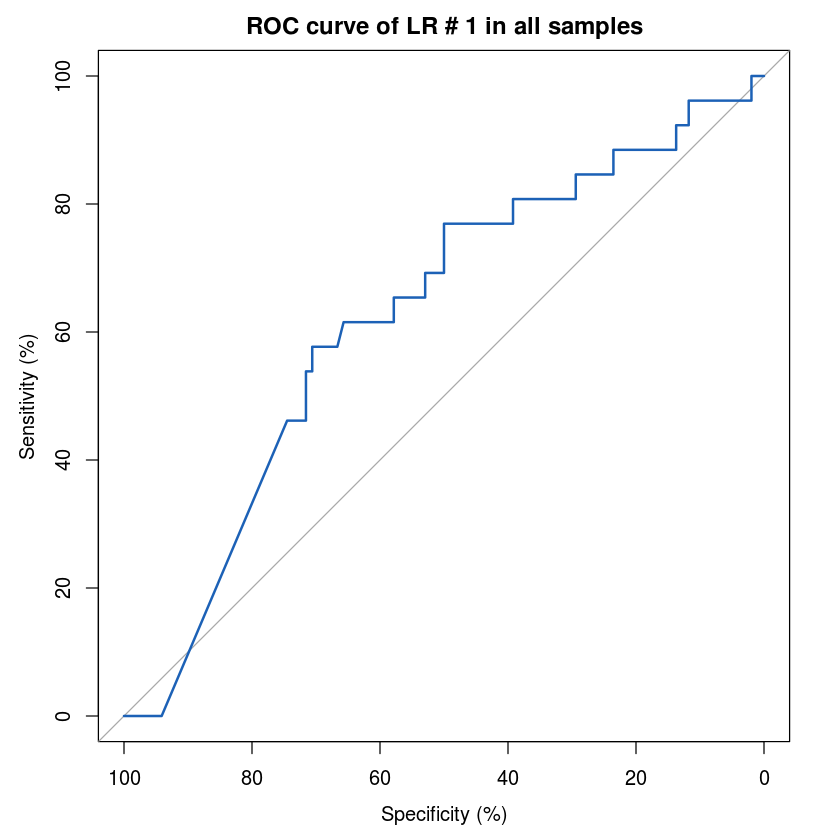


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 98 controls (data_thresh$outcome rHGG) < 24 cases (data_thresh$outcome txe).
Area under the curve: 55.55%

Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9551  -0.7619  -0.6290  -0.5247   2.0838  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6954     0.3593  -4.718 2.38e-06 ***
cbvn_nlin     0.1477     0.2084   0.709    0.478    
cni           0.2087     0.1397   1.494    0.135    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 140.98  on 130  degrees of freedom
Residual deviance: 137.55  on 128  degrees of freedom
AIC:

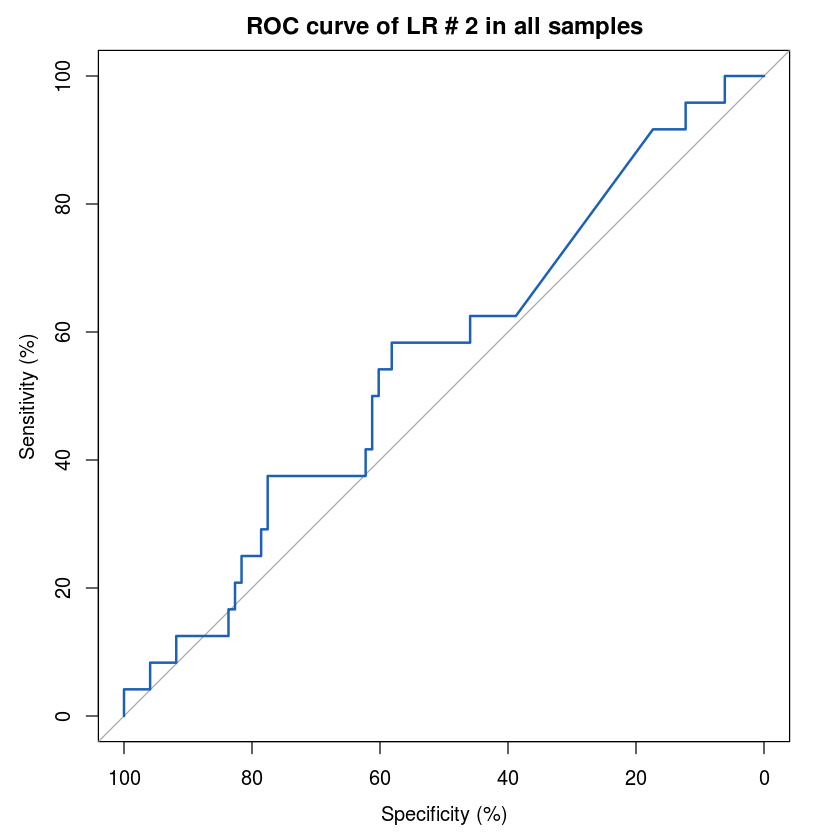


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 101 controls (data_thresh$outcome rHGG) < 30 cases (data_thresh$outcome txe).
Area under the curve: 61.5%

Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9108  -0.7720  -0.6484  -0.5977   1.9331  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.53101    0.34979  -4.377  1.2e-05 ***
cbvn_nlin    0.03587    0.19714   0.182    0.856    
cni          0.14144    0.12595   1.123    0.261    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 137.49  on 128  degrees of freedom
Residual deviance: 136.11  on 126  degrees of freedom
AIC:

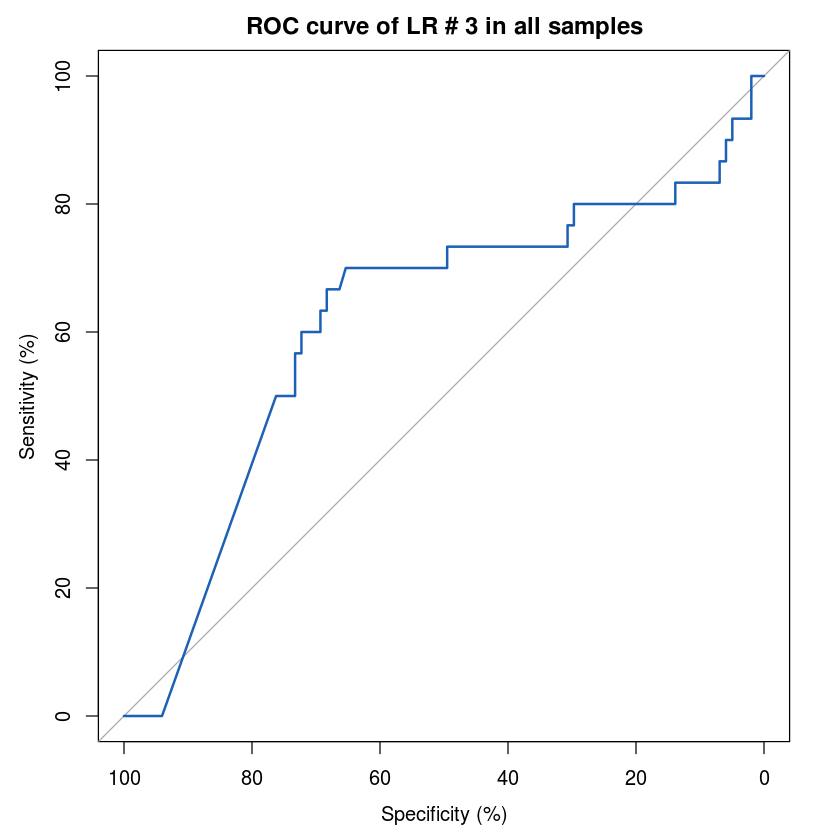


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 100 controls (data_thresh$outcome rHGG) < 29 cases (data_thresh$outcome txe).
Area under the curve: 58.12%

Call:
glm(formula = lr_formula, family = binomial, data = data_thresh)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9128  -0.7746  -0.6454  -0.5804   1.9218  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.51413    0.34565  -4.381 1.18e-05 ***
cbvn_nlin   -0.02062    0.20134  -0.102    0.918    
cni          0.16408    0.13624   1.204    0.228    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 147.03  on 137  degrees of freedom
Residual deviance: 145.53  on 135  degrees of freedom
AIC

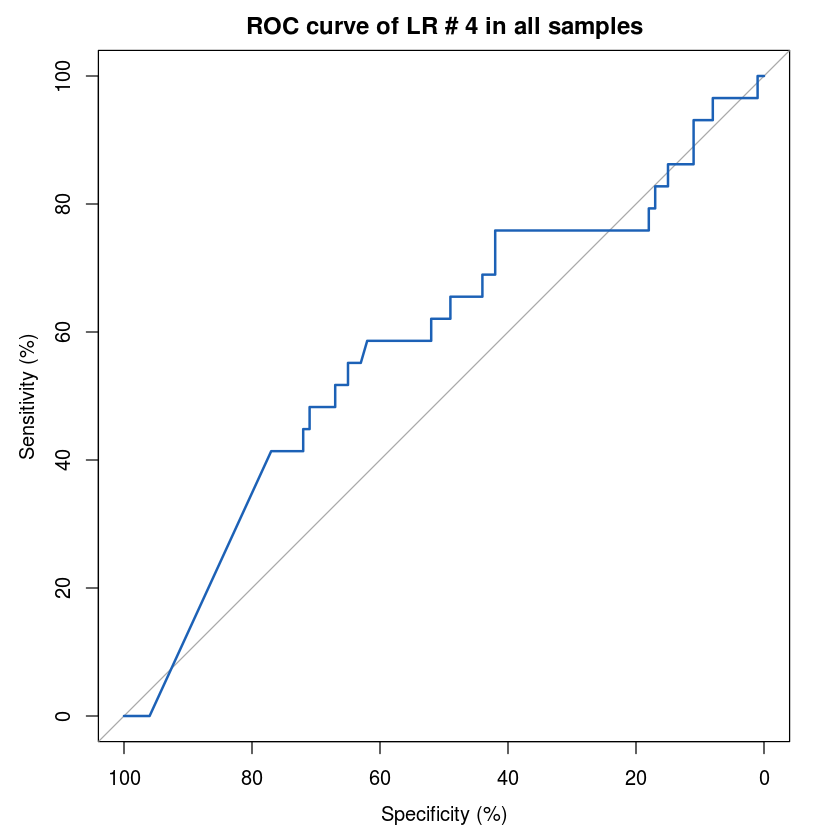


Call:
plot.roc.default(x = data_thresh$outcome, predictor = fit.probs.data_thresh,     levels = c("rHGG", "txe"), percent = TRUE, col = "#1c61b6",     main = paste("ROC curve of LR #", fold, "in all samples"))

Data: fit.probs.data_thresh in 107 controls (data_thresh$outcome rHGG) < 31 cases (data_thresh$outcome txe).
Area under the curve: 54.91%


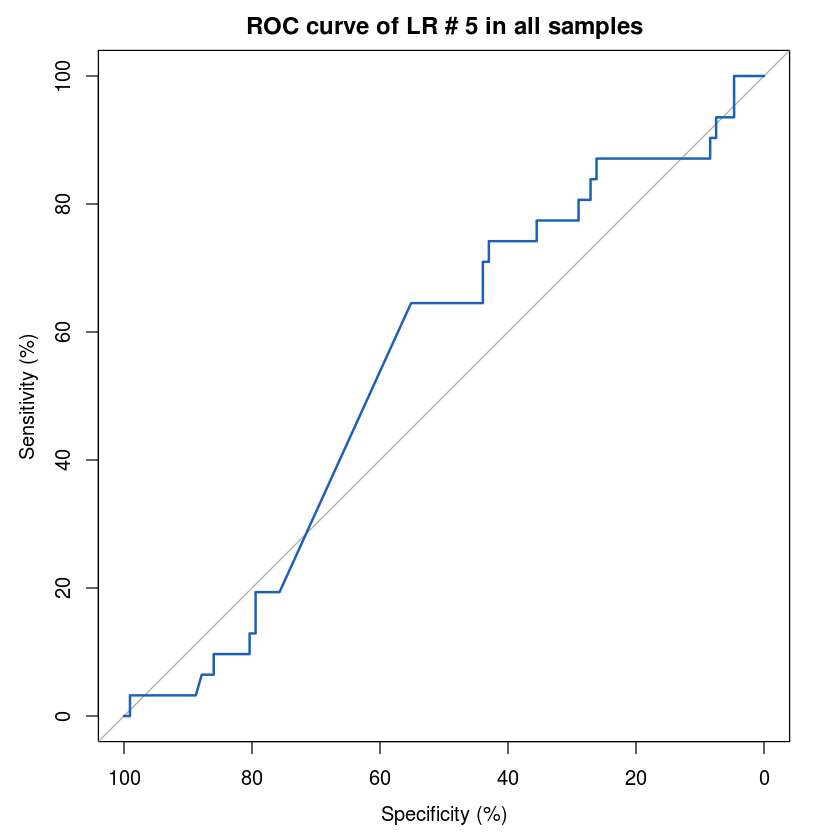

In [56]:
scores_lr_CEL  = data.frame(
                        folds = NA, 
                        features = NA, 
                        auc_4folds = NA,
                        acc_4folds = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        acc_CV = NA,
                        sens_CV = NA, 
                        spec_CV = NA
                       )

for (fold in c(1:5)){
    ## divide data 
    data_cel = data[which(data$in_CEL == 1),]
    data_thresh = data_cel[which(data_cel$fold != fold),]
    data_pred = data_cel[which(data_cel$fold == fold),]
    
    ## cycle through cols to normalize: 
    for (col in features_mri){        
        ## standardization: 
        med_col = median(data_thresh[,col], na.rm = T)
        sd_col = sd(data_thresh[,col], na.rm = T)
        
        data_thresh[,col] = (data_thresh[,col]-med_col)/sd_col
        data_pred[,col] = (data_pred[,col]-med_col)/sd_col

        ##missing value filling: 
        data_thresh[,col] = ifelse(is.na(data_thresh[,col]), med_col, data_thresh[,col])
        data_pred[,col] = ifelse(is.na(data_pred[,col]), med_col, data_pred[,col])
    }
    
    ## create logReg for fold: 
    outcome = "outcome"
    features = c('cbvn_nlin',
                 'cni')
    features.addsign <- paste(features, collapse = "+")
    lr_formula = as.formula(paste(outcome, features.addsign, sep = "~"))
    lr.fit = glm(lr_formula, data = data_thresh, family = binomial)
    print(summary(lr.fit))
    ## predict on training data: (4folds)
    fit.probs.data_thresh = predict(lr.fit, data_thresh, family = binomial, type = "response")
    fit.preds.data_thresh = as.factor(ifelse(fit.probs.data_thresh > 0.25, "txe", 'rHGG'))
    print(plot.roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("rHGG", "txe"), 
          percent = TRUE, col = "#1c61b6", main = paste("ROC curve of LR #", fold, "in all samples")))
    auc = auc(roc(data_thresh$outcome, fit.probs.data_thresh, levels=c("txe", "rHGG"), 
          percent = TRUE))
    
    acc =  confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$overall['Accuracy']
    sens = confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$byClass['Sensitivity']
    spec = confusionMatrix(data = fit.preds.data_thresh, reference = data_thresh$outcome)$byClass['Specificity']
    
    ## predict on test   data: (5th fold)
    fit.probs.data_pred = predict(lr.fit, data_pred, family = binomial, type = "response")

    thresh = 0.25
    fit.preds.data_pred = as.factor(ifelse(fit.probs.data_pred > thresh, "txe", 'rHGG'))

    ## save the coefficients & p-values

    acc_5 =  confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$overall['Accuracy']
    sens_5 = confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$byClass['Sensitivity']
    spec_5 = confusionMatrix(data = fit.preds.data_pred, reference = data_pred$outcome)$byClass['Specificity']

    SAVE_FOLD = c(fold, features.addsign, auc, acc, sens, spec, acc_5, sens_5, spec_5)
    scores_lr_CEL = rbind(scores_lr_CEL, SAVE_FOLD)
    
}





In [57]:
scores_lr_CEL = scores_lr_CEL[-1,-c(1,2)]

scores_lr_CEL

scores_lr_CEL = apply(scores_lr_CEL , c(1,2), as.numeric)

data.frame(mean = apply(scores_lr_CEL , 2, mean), med = apply(scores_lr_CEL , 2, median), sd = apply(scores_lr_CEL, 2, sd))



,auc_4folds,acc_4folds,sens_4folds,spec_4folds,acc_CV,sens_CV,spec_CV
2,62.3868778280543,0.59375,0.57843137254902,0.653846153846154,0.411764705882353,0.36,0.555555555555556
3,55.5484693877551,0.754098360655738,0.908163265306122,0.125,0.675,0.931034482758621,0
4,61.5016501650165,0.66412213740458,0.663366336633663,0.666666666666667,0.419354838709677,0.5,0
5,58.1206896551724,0.542635658914729,0.53,0.586206896551724,0.606060606060606,0.592592592592593,0.666666666666667
6,54.9140789870365,0.536231884057971,0.504672897196262,0.645161290322581,0.625,0.65,0.5


,mean,med,sd
auc_4folds,58.4943532,58.1206897,3.38495947
acc_4folds,0.6181676,0.5937500,0.09165662
sens_4folds,0.6369268,0.5784314,0.16325932
spec_4folds,0.5353762,0.6451613,0.23147217
acc_CV,0.5474360,0.6060606,0.12302142
sens_CV,0.6067254,0.5925926,0.21184460
spec_CV,0.3444444,0.5000000,0.32010801


## random forest


In [58]:
scores_rf  = data.frame(folds = NA, 
                        auc_4folds = NA,
                        acc_4folds = NA,
                        sens_4folds = NA, 
                        spec_4folds = NA, 
                        acc_CV = NA,
                        sens_CV = NA, 
                        spec_CV = NA
                       )

In [59]:
## let's extract confusion matrix and put that in a data frame: 
outcome_exp_template = data.frame(folds = NA,
tr_txe_pct = NA, 
cv_txe_pct = NA, 
tr_outtxe_predtxe = NA, 
tr_outtxe_predrHGG = NA, 
tr_outrHGG_predtxe = NA, 
tr_outrHGG_predrHGG = NA, 
cv_outtxe_predtxe = NA, 
cv_outtxe_predrHGG = NA, 
cv_outrHGG_predtxe = NA, 
cv_outrHGG_predrHGG = NA, 
varImp_in_CEL = NA, 
varImp_cbvn_nlin = NA, 
varImp_recov_npar = NA, 
varImp_ccri = NA, 
varImp_cni = NA, 
varImp_ncho = NA, 
varImp_ncre = NA, 
varImp_nnaa = NA, 
varImp_nfa.1 = NA, 
varImp_nadc.1 = NA, 
varImp_hasDiffu = NA, 
varImp_hasPerf = NA, 
varImp_hasSpec = NA)

In [60]:
scores_rf = outcome_exp_template

In [61]:
## let's begin by running experiments for anatomic features only: 
## for each experiment, we'll run the random forest with a variety of parameters 

for (fold in c(1:5)){
    set.seed(fold)
    
    ## define features and outcome: 
    outcome = "outcome"
    features = c('in_CEL', 'cbvn_nlin',
                 'ccri', 'cni', 'ncho', 'ncre', 'nnaa', 'nfa.1', 'nadc.1')
    features.addsign <- paste(features, collapse = "+")
    rf_formula = as.formula(paste(outcome, features.addsign, sep = "~"))
    
    ## define training and testing (from the training) basically for x-val: 
    
    ## divide data 
    data_thresh = data[which(data$fold != fold),]
    data_pred = data[which(data$fold == fold),]
    
    ## cycle through cols to normalize: 
    for (col in features_mri){        
        ## standardization: 
        med_col = median(data_thresh[,col], na.rm = T)
        sd_col = sd(data_thresh[,col], na.rm = T)
        
        data_thresh[,col] = (data_thresh[,col]-med_col)/sd_col
        data_pred[,col] = (data_pred[,col]-med_col)/sd_col

        ##missing value filling: 
        data_thresh[,col] = ifelse(is.na(data_thresh[,col]), med_col, data_thresh[,col])
        data_pred[,col] = ifelse(is.na(data_pred[,col]), med_col, data_pred[,col])
    }    
    
    rf_med = randomForest(formula = rf_formula, 
             data = data_thresh, mtry = 3, nodesize = 1)
    importance_rf_med = importance(rf_med)
    
    thresh_med_preds    = predict(rf_med, data_thresh)
    thresh_med_conf_mat = confusionMatrix(thresh_med_preds, data_thresh$outcome)
    thresh_sens         = confusionMatrix(thresh_med_preds, data_thresh$outcome)$byClass['Sensitivity']
    thresh_spec         = confusionMatrix(thresh_med_preds, data_thresh$outcome)$byClass['Specificity']
    thresh_acc          = confusionMatrix(thresh_med_preds, data_thresh$outcome)$overall['Accuracy']
    
    cv_med_preds = predict(rf_med, data_pred)
    cv_med_conf_mat = confusionMatrix(cv_med_preds, data_pred$outcome)
    cv_sens         = confusionMatrix(cv_med_preds, data_pred$outcome)$byClass['Sensitivity']
    cv_spec         = confusionMatrix(cv_med_preds, data_pred$outcome)$byClass['Specificity']
    cv_acc          = confusionMatrix(cv_med_preds, data_pred$outcome)$overall['Accuracy']
    
    
    tr_txe_pct = table(data_thresh$outcome)['txe']/sum(table(data_thresh$outcome)['txe'], table(data_thresh$outcome)['rHGG'])
    cv_txe_pct = table(data_pred$outcome)['txe']/sum(table(data_pred$outcome)['txe'], table(data_pred$outcome)['rHGG'])

    scores_rf[fold,'folds'] = fold
    scores_rf[fold,'tr_txe_pct'] = tr_txe_pct
    scores_rf[fold,'cv_txe_pct'] = cv_txe_pct
    
    scores_rf[fold,'tr_acc'] = thresh_acc
    scores_rf[fold,'tr_sens'] = thresh_sens
    scores_rf[fold,'tr_spec'] = thresh_spec
    
    scores_rf[fold,'tr_outtxe_predtxe'] = rf_med$confusion['txe', 'txe']
    scores_rf[fold,'tr_outtxe_predrHGG'] = rf_med$confusion['txe', 'rHGG']
    scores_rf[fold,'tr_outrHGG_predtxe'] = rf_med$confusion['rHGG', 'txe']
    scores_rf[fold,'tr_outrHGG_predrHGG'] = rf_med$confusion['rHGG', 'rHGG']
    
    scores_rf[fold,'cv_acc'] = cv_acc
    scores_rf[fold,'cv_sens'] = cv_sens
    scores_rf[fold,'cv_spec'] = cv_spec
    
    scores_rf[fold,'cv_outtxe_predtxe'] = cv_med_conf_mat$table['txe', 'txe']
    scores_rf[fold,'cv_outtxe_predrHGG'] = cv_med_conf_mat$table['txe', 'rHGG']
    scores_rf[fold,'cv_outrHGG_predtxe'] = cv_med_conf_mat$table['rHGG', 'txe']
    scores_rf[fold,'cv_outrHGG_predrHGG'] = cv_med_conf_mat$table['rHGG', 'rHGG']
    
    for (col in features){
        varImp_col = paste('varImp_', col, sep = "")
            scores_rf[fold, varImp_col] = importance_rf_med[col,]
    }
      
    fold = fold + 1

}

In [62]:
scores_rf

folds,tr_txe_pct,cv_txe_pct,tr_outtxe_predtxe,tr_outtxe_predrHGG,tr_outrHGG_predtxe,tr_outrHGG_predrHGG,cv_outtxe_predtxe,cv_outtxe_predrHGG,cv_outrHGG_predtxe,⋯,varImp_nadc.1,varImp_hasDiffu,varImp_hasPerf,varImp_hasSpec,tr_acc,tr_sens,tr_spec,cv_acc,cv_sens,cv_spec
1,0.2227074,0.2903226,0,51,8,170,1,1,17,⋯,13.90165,NA,NA,NA,0.9650655,1,0.8431373,0.7096774,0.9772727,0.05555556
2,0.2280702,0.2698413,5,47,9,167,0,1,17,⋯,15.22791,NA,NA,NA,0.9561404,1,0.8076923,0.7142857,0.9782609,0.00000000
3,0.2435897,0.2105263,4,53,11,166,2,5,10,⋯,13.72572,NA,NA,NA,0.9529915,1,0.8070175,0.7368421,0.8888889,0.16666667
4,0.2510823,0.1833333,2,56,9,164,1,0,10,⋯,15.64224,NA,NA,NA,0.9610390,1,0.8448276,0.8333333,1.0000000,0.09090909
5,0.2396694,0.2244898,4,54,6,178,0,4,11,⋯,15.79375,NA,NA,NA,0.9504132,1,0.7931034,0.6938776,0.8947368,0.00000000


In [63]:
summary(scores_rf)

     folds     tr_txe_pct       cv_txe_pct     tr_outtxe_predtxe
 Min.   :1   Min.   :0.2227   Min.   :0.1833   Min.   :0        
 1st Qu.:2   1st Qu.:0.2281   1st Qu.:0.2105   1st Qu.:2        
 Median :3   Median :0.2397   Median :0.2245   Median :4        
 Mean   :3   Mean   :0.2370   Mean   :0.2357   Mean   :3        
 3rd Qu.:4   3rd Qu.:0.2436   3rd Qu.:0.2698   3rd Qu.:4        
 Max.   :5   Max.   :0.2511   Max.   :0.2903   Max.   :5        
 tr_outtxe_predrHGG tr_outrHGG_predtxe tr_outrHGG_predrHGG cv_outtxe_predtxe
 Min.   :47.0       Min.   : 6.0       Min.   :164         Min.   :0.0      
 1st Qu.:51.0       1st Qu.: 8.0       1st Qu.:166         1st Qu.:0.0      
 Median :53.0       Median : 9.0       Median :167         Median :1.0      
 Mean   :52.2       Mean   : 8.6       Mean   :169         Mean   :0.8      
 3rd Qu.:54.0       3rd Qu.: 9.0       3rd Qu.:170         3rd Qu.:1.0      
 Max.   :56.0       Max.   :11.0       Max.   :178         Max.   :2.0      
 cv_ou